Iter 0 Testing Accuracy=0.9339005
Iter 1 Testing Accuracy=0.9339533
Iter 2 Testing Accuracy=0.93411183
Iter 3 Testing Accuracy=0.93411183
Iter 4 Testing Accuracy=0.93411183
Iter 5 Testing Accuracy=0.93411183
Iter 6 Testing Accuracy=0.93411183
Iter 7 Testing Accuracy=0.93411183
Iter 8 Testing Accuracy=0.93411183
Iter 9 Testing Accuracy=0.93411183
In total 18926 test samples, correct accuracy: 0.9341118038676952
[[    0  1247]
 [    0 17679]]
recall:  1.0


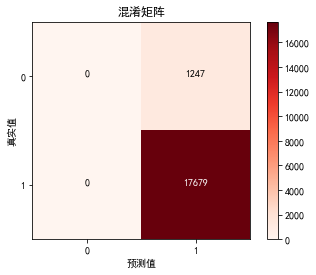

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Apr  4 11:40:07 2018

@author: weizhong
"""

import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np
import random
import math
import matplotlib.pyplot as plt

#数据集相关常数
DATA_SIZE = 57348
INPUT_NODE = 460
OUTPUT_NODE = 2
X_SIZE = 23
Y_SIZE = 20
NUM_CHANNELS = 1
NUM_LABELS = 2

#配置神经网络的参数
#第一层卷积层的尺寸和深度
CONV1_DEEP = 32
CONV1_SIZE = 5
#第二层卷积层的尺寸和深度
CONV2_DEEP = 64
CONV2_SIZE = 5

FC_SIZE = 1024 #全连接层的节点个数

BATCH_SIZE = 100 #

LEARNING_RATE = 1e-4 #基础学习率

LEANING_RATE_DECAY = 0.99 #学习率的衰减率

TRAINING_STEPS= 10 #训练轮数

#不同类的惩罚系数
LOSS_COEF = [1, 10]

#初始化权值
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=1) #生成一个截断的正态分布
    return tf.Variable(initial)
    #return tf.Variable(tf.zeros(shape))

#初始化偏置
def bias_variable(shape):
    initial = tf.truncated_normal(shape,stddev=1)
    return tf.Variable(initial)
    #return tf.Variable(tf.zeros(shape))

#卷积层
def conv2d(x,W):
    #input tensor of shape [batch, in_height, in_width, in_channels]
    #filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]
    #strides[0]=strides[3]=1. strides[1]代表ｘ方向的步长，strids[2]代表ｙ方向的步长
    #padding: A string from "SAME", "VALID"
    return tf.nn.conv2d(x,W,strides=[1,1,1,1], padding='SAME')

#池化层
def max_pool(x):
    #ksize [1,x,y,1]
    return tf.nn.max_pool(x,ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def cnn(x_train, x_test, y_train, y_test):
    x_train_size = np.size(x_train, 0)
    #定义两个placeholder
    x = tf.placeholder(tf.float32, [None, INPUT_NODE])#23*20
    y = tf.placeholder(tf.float32, [None, OUTPUT_NODE])

    #改变x的格式转为４Ｄ的向量【batch, in_height, in_width, in_channels]
    x_image = tf.reshape(x,[-1, X_SIZE, Y_SIZE, 1])

    #初始化第一个卷积层的权值和偏量
    W_conv1 = weight_variable([CONV1_SIZE,CONV1_SIZE,NUM_CHANNELS,CONV1_DEEP])#5*5的采样窗口，３２个卷积核从4个平面抽取特征
    b_conv1 = bias_variable([CONV1_DEEP])#每一个卷积核一个偏置值

    #把x_image和权值向量进行卷积，再加上偏置值，然后应用于relu激活函数
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool(h_conv1)#进行max-pooling,12-by-40

    #初始化第二个卷积层的权值和偏置
    W_conv2 = weight_variable([CONV2_SIZE,CONV2_SIZE,CONV1_DEEP,CONV2_DEEP]) #5*5的采样窗口，64个卷积核从32个平面抽取特征
    b_conv2 = bias_variable([CONV2_DEEP]) #每一个卷积核一个偏置值

    #把H_pool1和权值向量进行卷积，再加上偏置值，然后应用于relu激活函数
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool(h_conv2)#6-by-5

    #23*20的图片第一次卷积后还是23*20,第一次池化后变为12*10
    #第二次卷积后为12*10,第二次池化后变为6*5
    #进过上面操作后得到64张6*5的平面

    #初始化第一全链接层的权值
    W_fc1 = weight_variable([6*5*CONV2_DEEP,FC_SIZE]) #上一层有6*10*64个神经元,全连接层有1024个神经元
    b_fc1 = bias_variable([FC_SIZE])

    #把池化层2的输出扁平化为1维
    h_pool2_flat = tf.reshape(h_pool2,[-1,6*5*CONV2_DEEP])
    #求第一个全连接层的输出
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    #keep_prob用了表示神经元的输出概率
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    #初始化第二个全连接层
    W_fc2 = weight_variable([FC_SIZE,OUTPUT_NODE])
    b_fc2 = bias_variable([OUTPUT_NODE])

    #计算输出
    prediction = tf.nn.softmax(tf.matmul(h_fc1_drop,W_fc2) + b_fc2)
    # 结果存放在一个布尔列表中
    correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
    #交叉熵代价函数
    #cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=prediction))
    #自定义损失函数，因为结合位点的标签是[0,1]共有3778，非结合位点的标签是[1,0]有53570，是非平衡数据集，
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=prediction)
    y1 = tf.argmax(y,1)
    yshape = tf.shape(y)
    a = tf.ones([yshape[0]],dtype=tf.int64)
    loss = tf.reduce_mean( tf.where( tf.greater_equal( y1,a), cross_entropy * LOSS_COEF[1], cross_entropy * LOSS_COEF[0]))
    #使用AdamOptimizer进行优化
    train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

    #求准确率
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        n_batch = math.ceil(x_train_size/BATCH_SIZE)
        for epoch in range(TRAINING_STEPS):
            for batch in range(n_batch):
                start = (batch * BATCH_SIZE) % x_train_size
                end = min(start + BATCH_SIZE, x_train_size)
                batch_xs = x_train[start:end]
                batch_ys = y_train[start:end]
                sess.run(train_step,feed_dict={x:batch_xs, y: batch_ys, keep_prob: 0.7})

            acc = sess.run(accuracy, feed_dict={x: x_test, y: y_test, keep_prob: 1.0})
            print("Iter " + str(epoch) + " Testing Accuracy=" + str(acc))
        pred = sess.run(prediction, feed_dict={x: x_test, y: y_test, keep_prob: 1.0})
        return pred


# 绘制混淆矩阵的函数
# 参数1  cm 混淆矩阵中显示的数值 二维数组
# 参数2 cmap 混淆矩阵中的颜色
# 参数3 title 标题
def plot_confusion_matrix(cm, classes, title='混淆矩阵', cmap=plt.cm.Reds):
    # imshow() 表示绘制并显示二维图 有18个参数
    # 参数1 X 混淆矩阵中显示的数值 二维数组
    # 参数2 cmap 颜色 plt.cm.Blues表示蓝色 plt.cm.Reds表示红色 plt.cm.Greens表示绿色
    # 参数5 interpolation 插值法 一般有如下值
    #     nearest 最近邻插值法
    #     bilinear 双线性插值法
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.imshow(cm, cmap=cmap, interpolation="nearest")
    plt.title(title)  # 标题
    plt.colorbar()  # 显示颜色的进度条
    tick_marks = np.arange(2)  # [0 1]
    plt.xticks(tick_marks, classes)  # 对x轴上分类进行标记
    plt.yticks(tick_marks, classes)  # 对y轴上分类进行标记

    thresh = np.mean(cm)
    for i in range(2):
        for j in range(2):
            plt.text(i, j, cm[j][i],
                     horizontalalignment='center',
                     color='white' if cm[i][j] >= thresh else 'black')

    plt.xlabel('预测值')
    plt.ylabel('真实值')


# target是N行2列的数组，第1列的值为1表示该行样本为负类，第2列的值为1表示正类
def split_dataset(data: np.ndarray, target: np.ndarray, rate=0.33):
    # 划分正样本和负样本集
    ind = np.equal(target[:, 0], 1)
    negative_data = data[ind]
    positive_data = data[~ind]
    negative_target = target[ind]
    positive_target = target[~ind]

    # 对正样本集和负样本集按比例(rate)划分训练集和测试集
    positive_x_train, positive_x_test, positive_y_train, positive_y_test = train_test_split(positive_data,positive_target, test_size=rate)
    negative_x_train, negative_x_test, negative_y_train, negative_y_test = train_test_split(negative_data,negative_target, test_size=rate)
    x_train = np.vstack((positive_x_train, negative_x_train))
    x_test = np.vstack((positive_x_test, negative_x_test))
    y_train = np.vstack((positive_y_train, negative_y_train))
    y_test = np.vstack((positive_y_test, negative_y_test))

    # 打乱数据集
    train_num = x_train.shape[0]
    ind_train = list(range(train_num))
    random.shuffle(ind_train)
    x_train = x_train[ind_train]
    y_train = y_train[ind_train]

    test_num = x_test.shape[0]
    ind_test = list(range(test_num))
    random.shuffle(ind_test)
    x_test = x_test[ind_test]
    y_test = y_test[ind_test]

    return x_train, x_test, y_train, y_test


# load benchmark dataset
data = sio.loadmat('PDNA-224-PSSM-11.mat')

X = data['data']
Y = data['target']
X = X.reshape(DATA_SIZE, -1)

X_train, X_test, Y_train, Y_test = split_dataset(X, Y)

pred_Y = cnn(X_train, X_test, Y_train, Y_test)

correct = 0
total = X_test.shape[0]

for i in range(total):
    if (Y_test[i] == pred_Y[i]).all():
        correct += 1
print("In total {} test samples, correct accuracy: {}".format(total, correct / total))

Y1 = np.ndarray([total])
PY = np.ndarray([total])
for i in range(total):
    if Y_test[i][0] == 1:
        Y1[i] = 0
    else:
        Y1[i] = 1

    if pred_Y[i][0] == 1:
        PY[i] = 0
    else:
        PY[i] = 1
cnf_matrix = confusion_matrix(Y1, PY)

print(cnf_matrix)
recall = cnf_matrix[1][1] / (cnf_matrix[1][0] + cnf_matrix[1][1])
print('recall: ', recall)
plot_confusion_matrix(cnf_matrix, [0, 1], cmap=plt.cm.Reds)


In [ ]:
Iter 0 Testing Accuracy=0.93411183
Iter 1 Testing Accuracy=0.93411183
Iter 2 Testing Accuracy=0.93411183
Iter 3 Testing Accuracy=0.93411183
Iter 4 Testing Accuracy=0.93411183
Iter 5 Testing Accuracy=0.93411183
Iter 6 Testing Accuracy=0.93411183
Iter 7 Testing Accuracy=0.93411183
Iter 8 Testing Accuracy=0.93411183
Iter 9 Testing Accuracy=0.93411183
Iter 10 Testing Accuracy=0.93411183
Iter 11 Testing Accuracy=0.93411183
Iter 12 Testing Accuracy=0.93411183
Iter 13 Testing Accuracy=0.93411183
Iter 14 Testing Accuracy=0.93411183
Iter 15 Testing Accuracy=0.93411183
Iter 16 Testing Accuracy=0.93411183
Iter 17 Testing Accuracy=0.93411183
Iter 18 Testing Accuracy=0.93411183
Iter 19 Testing Accuracy=0.93411183
In total 18926 test samples, correct accuracy: 0.9341118038676952
[[17679     0]
 [ 1247     0]]
recall:  0.0